In [1]:
#Python/Data
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
import numpy as np
import h5py as h5

#ML
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split
import tensorflow as tf

|        |        |        |  Calo Image  |           |           |
|:------:|:------:|:------:|:------------:|:---------:|:---------:|
| Cell E | Cell X | Cell Y | Cell 'Depth' | Layer 1 Z | Layer 2 Z |
|    0   |    1   |    2   |       3      |     4     |     5     |

| Truth   |        |
|:-------:|:------:|
|Truth $E$|$\theta$|

### Load the Data

In [2]:
#filename = 'layered_with0s.hdf5'
#filename = 'varphi_layered.hdf5'
filename = 'vartheta_layered.hdf5'
#filename = 'simple_test.hdf5'
h5_file = h5.File(filename,'r')
print(list(h5_file.keys()))
images = h5_file['calo_images']
truth = h5_file['truth']

print(images.shape)
print(truth.shape)
print(images.chunks[0]) #should be = batch_size
print(truth.chunks[0])

['calo_images', 'truth']
(3600000, 6, 3166)
(3600000, 2, 22)
100
100


In [3]:
N_Events = 1_000_000
#N_Events = 100_000
X = images[0:N_Events]
Y = truth[0:N_Events,0,0]
#Y_Mean = np.nanmean(Y)
#Y_StDev = np.nanstd(Y)
#Y = (Y - Y_Mean)/Y_StDev
#print(type(X))

In [4]:
(X_train, X_val, X_test,
Y_train, Y_val, Y_test) = data_split(X, Y, val=0.2, test=0.3,shuffle=True)

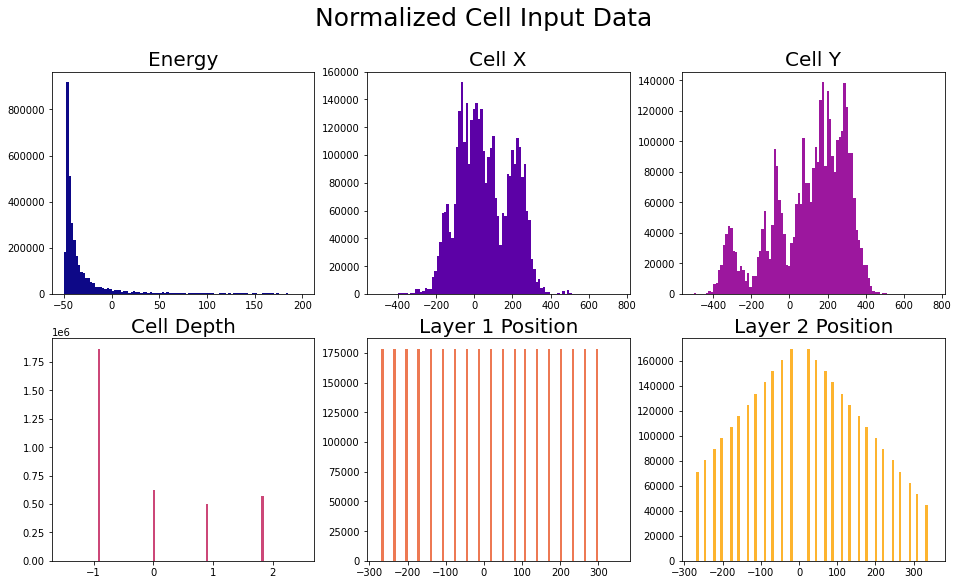

In [5]:
fig = plt.figure(figsize=(16,9))

#axsLeft = subfigs[0].subplots(2, 3, sharey=False)
#subfigs[0].set_facecolor('0.75')

cm = plt.cm.get_cmap('plasma')
cell_vars = ["Energy","Cell X","Cell Y","Cell Depth","Layer 1 Position", "Layer 2 Position"]
bins = [np.linspace(-50,200,101),np.linspace(-500,751,100),
        np.linspace(-500,751,100),np.linspace(-1.5,2.5,100), #,np.linspace(-25,25,100),
        np.linspace(-275,350,100),np.linspace(-275,350,100)]
data=[]

#plt.subplots_adjust(left=None, bottom=1, right=None, top=1.5, wspace=None, hspace=None)
for i in range(images.shape[1]):
    ax = plt.subplot(2, 3, i+1)
    #ax = axsLeft[int(i/3)][int(i/2)]
    data.insert(i,np.ravel(images[0:10000,i,:]))
    data[i] = data[i][data[i]!=0]
    plt.hist(data[i],bins=bins[i],color=cm(i/images.shape[1]))
    plt.title("%s"%(cell_vars[i]),fontsize=20)
    plt.suptitle("Normalized Cell Input Data",fontsize=25)
    
    
#axsRight = subfigs[1].subplots(1,1,sharey=False)
#plt.hist(Y_val,alpha=0.5,label="Validation Energy",orientation='horizontal')
#_ = plt.hist(Y_test,alpha=0.5,label="Test Energy",orientation='horizontal')
#plt.legend()
plt.savefig("Normalized_Cell_Data.pdf")

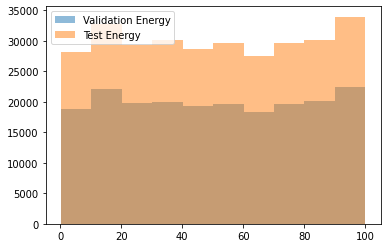

In [6]:
plt.hist(Y_val,alpha=0.5,label="Validation Energy")
_ = plt.hist(Y_test,alpha=0.5,label="Test Energy")
plt.legend()

In [7]:
def old_scheduler(epoch, lr):
    min_rate = 1.01e-6
    N_First = 50
    N_Epoch = 30
    
    if epoch > N_First and lr >= min_rate:
        
        if (epoch%N_Epoch == 0):
            exp = int(np.log10(lr))
        
            if (lr%10**exp==0):
                lr = lr*0.5
            else:
                lr = (10**float(exp-1))
        
    return tf.convert_to_tensor(lr)

#callbacks = tf.keras.callbacks.LearningRateScheduler(old_scheduler,verbose=1)

In [8]:
def step_decay(epoch, lr):
    min_rate = 1.01e-6
    N_start = 50
    N_epochs = 30
    
    if epoch > N_start and lr >= min_rate:
        if (epoch%N_epochs==0):
            return lr * 0.1
    return lr

callbacks = tf.keras.callbacks.LearningRateScheduler(step_decay,verbose=0)

In [9]:
def scheduler(epoch, lr):
    min_rate = 1.01e-6
    N_start = 20
    
    if epoch > N_start and lr >= min_rate:
        if (epoch%N_start==0):
            return lr * tf.math.exp(-0.1)
    
    return lr

#callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

In [10]:
learning_rate = 1e-4
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse' #mean-squared error
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 3166)  0           []                               
                                ]                                                                 
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    316700      ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    10100       ['activation[0][0]']         

2022-07-05 19:41:12.397547: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/global/home/users/ftoralesacosta/user_pkg/usr/lib:/global/home/users/ftoralesacosta/user_pkg/usr/lib64:/lib:/lib64:/usr/lib:/usr/lib64
2022-07-05 19:41:12.397572: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-07-05 19:41:12.397863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions

In [ ]:
the_fit = pfn.fit(X_train, Y_train,
                  epochs=300,
                  batch_size=400,
                  callbacks=[callbacks],
                  validation_data=(X_val, Y_val),
                  verbose=1)

2022-07-05 19:41:12.497130: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37992000000 exceeds 10% of free system memory.


Epoch 1/300
1248/1250 [============================>.] - ETA: 0s - loss: 724.5169 - acc: 0.0000e+00

2022-07-05 19:41:39.630237: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 15196800000 exceeds 10% of free system memory.


1250/1250 [==============================] - 23s 18ms/step - loss: 723.7980 - acc: 0.0000e+00 - val_loss: 263.8896 - val_acc: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/300
1250/1250 [==============================] - 17s 14ms/step - loss: 176.6149 - acc: 0.0000e+00 - val_loss: 110.8444 - val_acc: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/300
1250/1250 [==============================] - 17s 14ms/step - loss: 102.7778 - acc: 0.0000e+00 - val_loss: 58.8692 - val_acc: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/300
1250/1250 [==============================] - 17s 14ms/step - loss: 65.7878 - acc: 0.0000e+00 - val_loss: 108.8173 - val_acc: 0.0000e+00 - lr: 1.0000e-04
Epoch 5/300
1250/1250 [==============================] - 17s 14ms/step - loss: 54.5426 - acc: 0.0000e+00 - val_loss: 57.2198 - val_acc: 0.0000e+00 - lr: 1.0000e-04
Epoch 6/300
1250/1250 [==============================] - 17s 14ms/step - loss: 38.6279 - acc: 0.0000e+00 - val_loss: 70.6743 - val_acc: 0.0000e+00 - lr: 1.0000e-04
Epoch 7/300
1250/1250 

In [ ]:
pfn.layers
pfn.save("energy_regression.h5")
mypreds = pfn.predict(X_test,batch_size=400)

In [ ]:
np.save("predictions.npy",mypreds)
np.save("y_test.npy",Y_test)
np.save("x_test.npy",X_test)

In [ ]:
fig = plt.figure(figsize=(28,10))
ax = plt.subplot(1, 2, 1)
plt.scatter(Y_test,mypreds,alpha=0.3)
plt.xlabel("Y Test [GeV]",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
#plt.ylim(-0.01,100.01)
plt.ylim(-10,110)
plt.ylabel("Y Pred [GeV]",fontsize=22)
_ = plt.title("Prediction vs. Test",fontsize=26)
#FIXME: find indecies in mypreds where mypreds 50

ax = plt.subplot(1, 2, 2)
plt.plot(the_fit.history['loss'])
plt.plot(the_fit.history['val_loss'])
plt.title('Model Loss vs. Epoch',fontsize=26)
plt.text(0.73,0.73,"Step Decayed \n Learning Rate \n {:.1e} to {:.1e}".format(learning_rate,1e-6),
         transform=ax.transAxes,fontsize=20)
plt.ylabel('Mean-Squared Error',fontsize=22)
plt.yscale('log')
plt.xlabel('epoch',fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.tick_params(direction='in',right=True,top=True,which='minor')
plt.xlim([-1,301])
plt.legend(['train', 'validation'], loc='upper right',fontsize=22)
plt.savefig("varphi_StepDecay_Prediction_Test.pdf")

In [ ]:
#Binning
N = 50
E_Max = 100
E_Bins = np.linspace(0,E_Max,N)

#Goal: slices defined by bin of truthE, filled with prediction distributions
indecies = np.digitize(Y_test,E_Bins)
max_count = ((np.bincount(indecies).max()))
slices = np.empty((N,max_count))
slices.fill(np.nan)

counter = np.zeros(N,int)
avg_truth = np.zeros(N,float)

for pred,bin,truth in zip(mypreds,indecies,Y_test):
    slices[bin-1][counter[bin-1]] = pred
    counter[bin-1]+=1
    avg_truth[bin-1]+=truth

#Resoluton: stdev(pred)/avg_truth    
avg_truth = avg_truth/counter
stdev_pred = np.nanstd(slices,axis=1)
resolution = stdev_pred/avg_truth

In [ ]:
fig=plt.figure(figsize=(14,10))
plt.title("AI Codesign Resolution",fontsize=25)
plt.ylabel("$(\sigma_{E,\mathrm{Pred}}/E_\mathrm{Truth})$",fontsize=24)
plt.xlabel("$E_\mathrm{Truth}$ [GeV]",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
#plt.ylim(-0.02,0.4)
#plt.ylim(0,0.22)
plt.xlim(-0.01,100.01)
errors = 1.0/(np.sqrt(2*counter-2))*stdev_pred
ax = plt.subplot(1,1,1)
first_bin = 0
last_bin = N
plt.errorbar(avg_truth[first_bin:last_bin],resolution[first_bin:last_bin],yerr=errors[first_bin:last_bin],
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',marker="o",color='dodgerblue',alpha=0.7)
_ = plt.text(0.7,0.93,"Stat. Error: $\dfrac{\sigma}{\sqrt{2N-2} } $",transform=ax.transAxes,fontsize=20)
plt.savefig("resolution_plot.pdf")

In [ ]:
fig,axs = plt.subplots(int(N/10),10, figsize=(32, 16),sharex=False,sharey=True,constrained_layout=True)
for i in range(N):
    row = int(i/10)
    col = i%10
    ax = axs[row,col]
    if (col==0):
        ax.set_ylabel("Counts",fontsize=15)
    temp_bin = np.linspace(avg_truth[i]-2.0,avg_truth[i]+2.0,16)
    ax.set_title("%1.1f $ < E_\mathrm{Truth} < $%1.1f [GeV]"%(E_Bins[i],E_Bins[i+1]))
    ax.set_xlabel("Predicted Eenergy")
    ax.hist(slices[i],bins=temp_bin,label="Predicted Energies")
    ax.axvline(x=avg_truth[i],color='red',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Truth} = %1.2f$"%(avg_truth[i]))
    ax.legend(fontsize=7.5)
    ax.tick_params(direction='in',right=True,top=True,length=5)
plt.savefig("resolutions_slices.pdf")

In [ ]:
from copy import copy
from matplotlib.colors import LogNorm
fig, axes = plt.subplots(nrows=1, figsize=(14, 10), constrained_layout=True)
cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))
edges=np.linspace(-10,110,121)
h, xedges, yedges = np.histogram2d(Y_test, mypreds[:,0], bins=[edges, edges])
#xedges=yedges
pcm = axes.pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmin=1.0e-2,vmax=2.0e3), rasterized=True)
cb = fig.colorbar(pcm, ax=axes, pad=0)
cb.set_label("Counts",fontsize=22)
cb.ax.tick_params(labelsize=20)
axes.set_xlabel("Generated Energy",fontsize=22)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylim(-10,110)
plt.xlim(-10,110)
axes.set_ylabel("Predicted Energy",fontsize=25)
axes.set_title("Predicted vs. Generated Energy",fontsize=30)
plt.savefig("Gen_vs_Pred.pdf")
print(np.size(yedges))

In [ ]:
#Find the peak and zoom in
fig = plt.figure(figsize=(18,5))
plt.suptitle("Predictions",fontsize=25)
ax = plt.subplot(1, 2, 1)
plt.xlabel("Predicted Energy [GeV]",fontsize=18)
bins = np.linspace(0,100,300)
freq = plt.hist(mypreds, bins=bins)

ax = plt.subplot(1, 2, 2)
plt.xlabel("Predicted Energy [GeV]",fontsize=18)
plt.text(0.03,0.9,"[Zoomed In]",transform=ax.transAxes,fontsize=18)
maxbin = np.argmax(freq[0])
zoom = np.linspace(bins[maxbin]-0.01,bins[maxbin]+0.01,100)
mask = np.where(np.logical_and(mypreds>=bins[maxbin]-0.01, mypreds<=bins[maxbin]+0.01))[0]
_ = plt.hist(mypreds[mask],alpha=.3,color="black",bins=zoom)
print("%i / %i Events"%(len(mask),len(mypreds)),"[{:.3%}]".format( (len(mask)/len(mypreds)) ) )

In [ ]:
#plt.hist(np.count_nonzero(np.ravel(X_test[:,1,:])))
weird_data = X_test[mask]
bins = np.linspace(0,1000,20)
fig = plt.figure(figsize=(18,5))
ax = plt.subplot(1,2,1)
plt.hist(np.ravel(np.count_nonzero(X_test,axis=2)),bins=bins)
plt.title("Entire Image Dataset",fontsize=20)
ax = plt.subplot(1,2,2)
plt.title("Weird Cells",fontsize=20)
plt.hist(np.ravel(np.count_nonzero(weird_data,axis=2)),bins=bins)
plt.suptitle("Number of Cell Hits",fontsize=25)

In [ ]:
cm = plt.cm.get_cmap('plasma')
cell_vars = ["Energy","Cell X","Cell Y","Cell Depth","Layer 1 Position", "Layer 2 Position"]
bins = [np.linspace(0.01,500,200),np.linspace(-500,500,100),
        np.linspace(-500,1300,100),np.linspace(-1.5,2.5,100),
        np.linspace(-275,350,100),np.linspace(-275,350,100)]
data=[]
weird_data=X_test[mask]
fig = plt.figure(figsize=(18,9))
#plt.subplots_adjust(left=None, bottom=1, right=None, top=1.5, wspace=None, hspace=None)
for i in range(images.shape[1]):
    ax = plt.subplot(2, 3, i+1)
    data.insert(i,np.ravel(weird_data[:,i,:]))
    data[i] = data[i][data[i]!=0]
    plt.hist(data[i],bins=bins[i],color=cm(i/images.shape[1]))
    plt.title("%s"%(cell_vars[i]),fontsize=20)
    plt.suptitle("'Weird' Normalized Cell Input Data",fontsize=25)
plt.savefig("weird_Cell_Data.pdf")
    #plt.xlabel('%s [Normalized]'%(cell_vars[i]),fontsize=15)

In [ ]:
cm = plt.cm.get_cmap('plasma')
cell_vars = ["Energy","Cell X","Cell Y","Cell Depth","Layer 1 Position", "Layer 2 Position"]
bins = [np.linspace(0.01,500,200),np.linspace(-500,500,100),
        np.linspace(-500,1300,100),np.linspace(-1.5,2.5,100),
        np.linspace(-275,350,100),np.linspace(-275,350,100)]
weird_data=X_test[mask]
fig = plt.figure(figsize=(18,9))
#plt.subplots_adjust(left=None, bottom=1, right=None, top=1.5, wspace=None, hspace=None)
for i in range(images.shape[1]-1):
    ax = plt.subplot(2, 3, i+1)
    plt.scatter(np.ravel(weird_data[:,i,:]),np.ravel(weird_data[:,i+1,:]),s=2)
    plt.xlabel(cell_vars[i])
    plt.ylabel(cell_vars[i+1])
    #plt.title("%s"%(cell_vars[i]),fontsize=20)
    plt.suptitle("'Weird' Normalized Cell Scatter Plots",fontsize=25)
plt.savefig("weird_Cell_Data.pdf")